# Preprocessing (Scaling) Investigation

**The notebook provides a discussion of the validity of other scaling methods**

**And shows the functionality of the scaling function at the end**

- This notebook acts as a visulisation of the raw data globally, across both parameters inorder to help inform the method to for scaling the data, ie the parameter $\alpha$

- The final preprocessing function which uses this investigation is then presented in `src/preprocessor.py`

In [ ]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
np.random.seed(5)

from src import preprocessor
from src import decoder

In [2]:
preditor_prey_path = 'lotka_volterra_data.h5'

## Loading the data

In [3]:
preditor_prey_path = 'lotka_volterra_data.h5'
with h5py.File(preditor_prey_path, 'r') as full_data:
    trajectories = full_data["trajectories"][:] # (num_trajectories, num_time_points, predator or prey)
    time_values = full_data["time"][:]

## Simply display two random structures

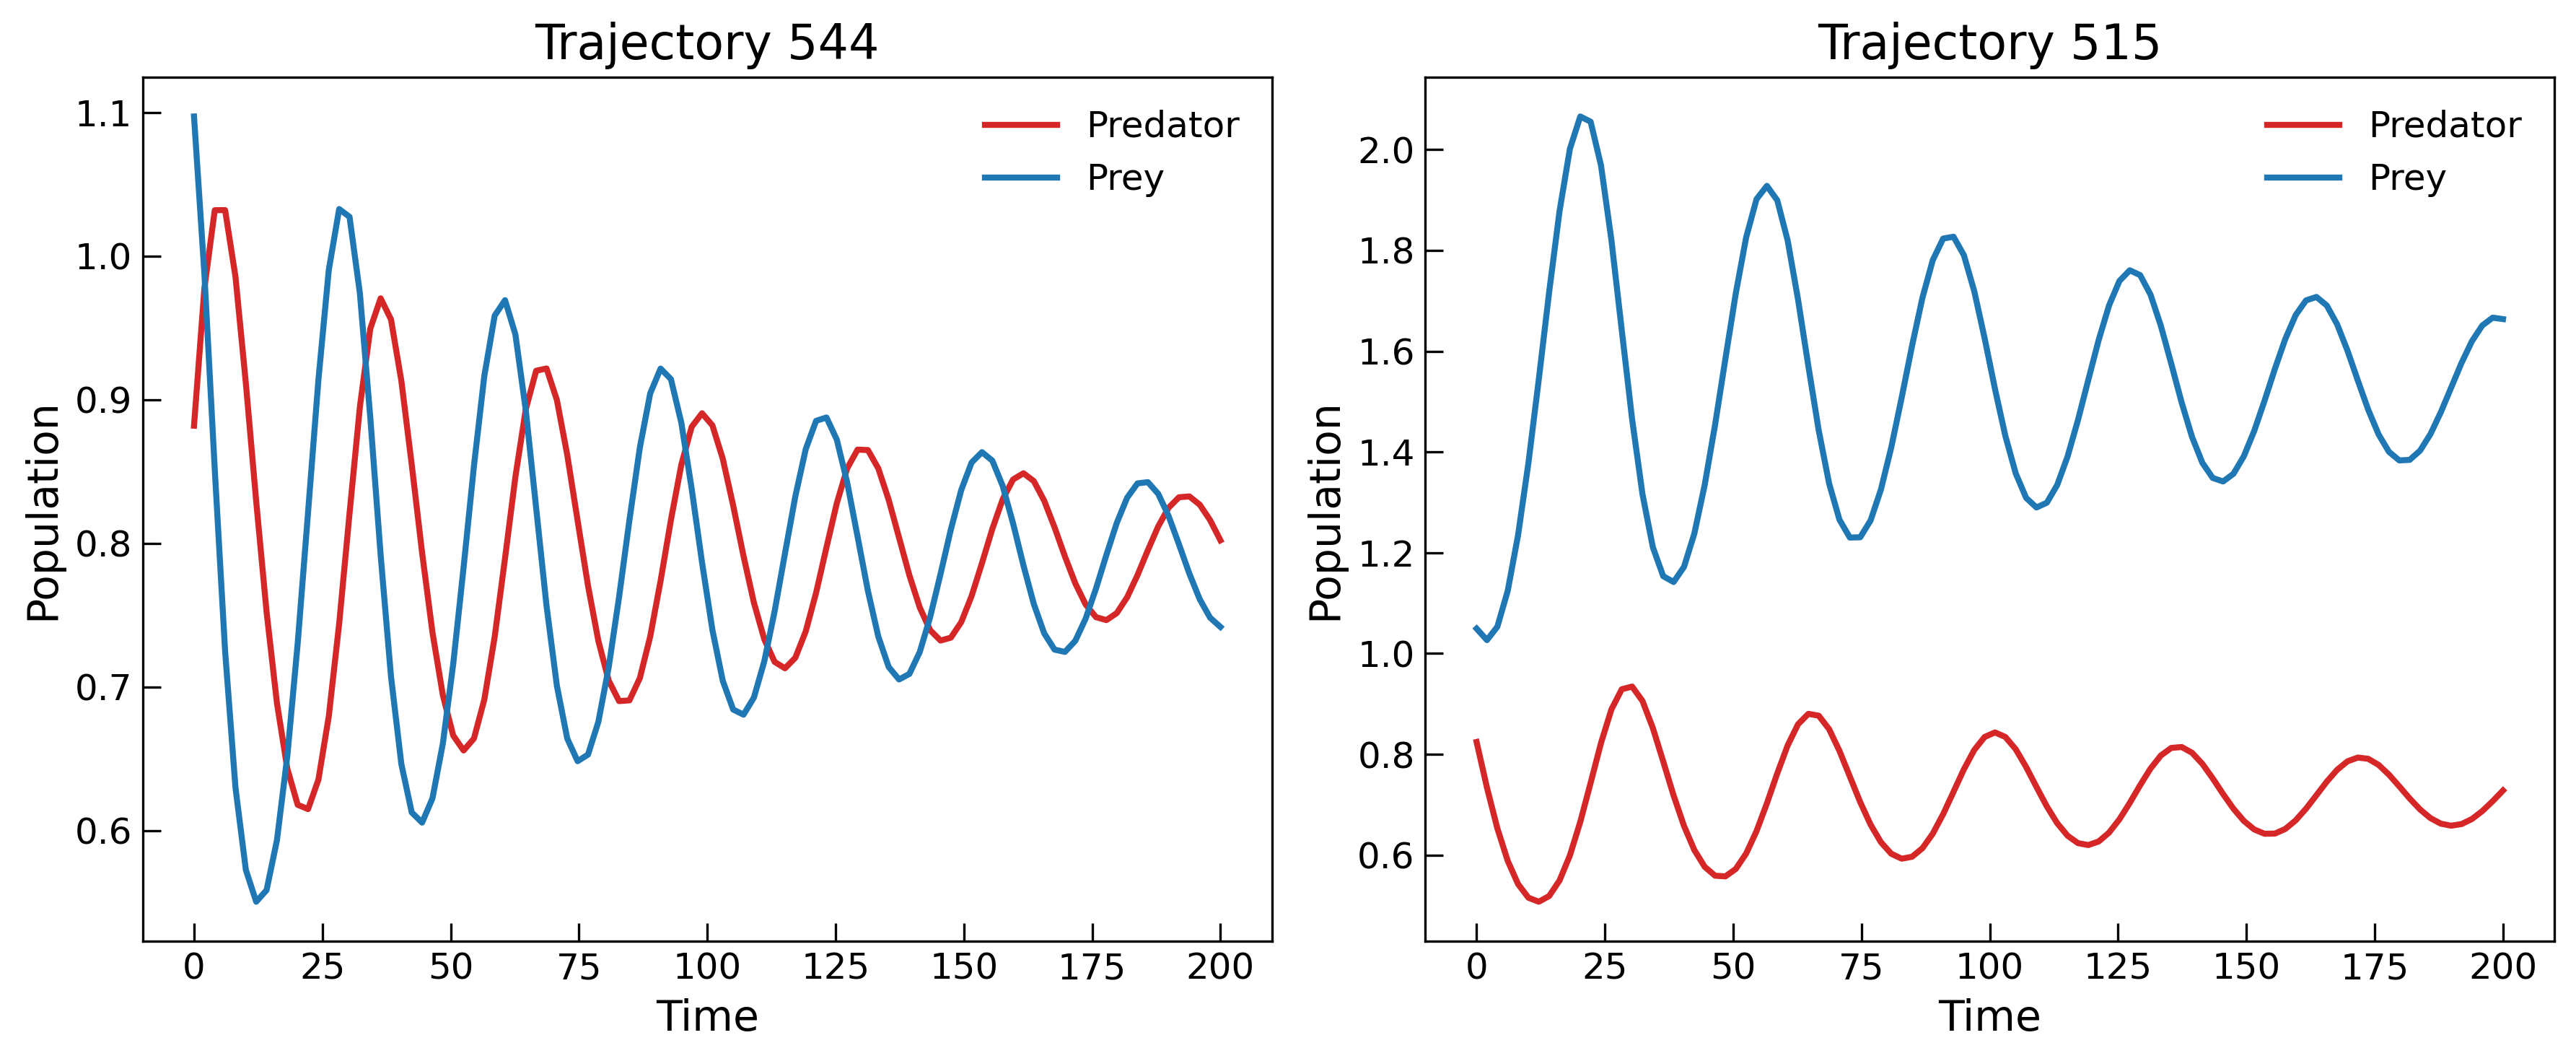

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
random_indices = np.random.choice(trajectories.shape[0], size=2, replace=False)

for i, ax in enumerate(axes):
    idx = random_indices[i]
    ax.plot(time_values, trajectories[idx, :, 1], label="Predator", color="tab:red", linewidth=2)
    ax.plot(time_values, trajectories[idx, :, 0], label="Prey", color="tab:blue", linewidth=2)
    
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Population", fontsize=14)
    ax.set_title(f"Trajectory {idx}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
    ax.legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.show()


## Global Distributions

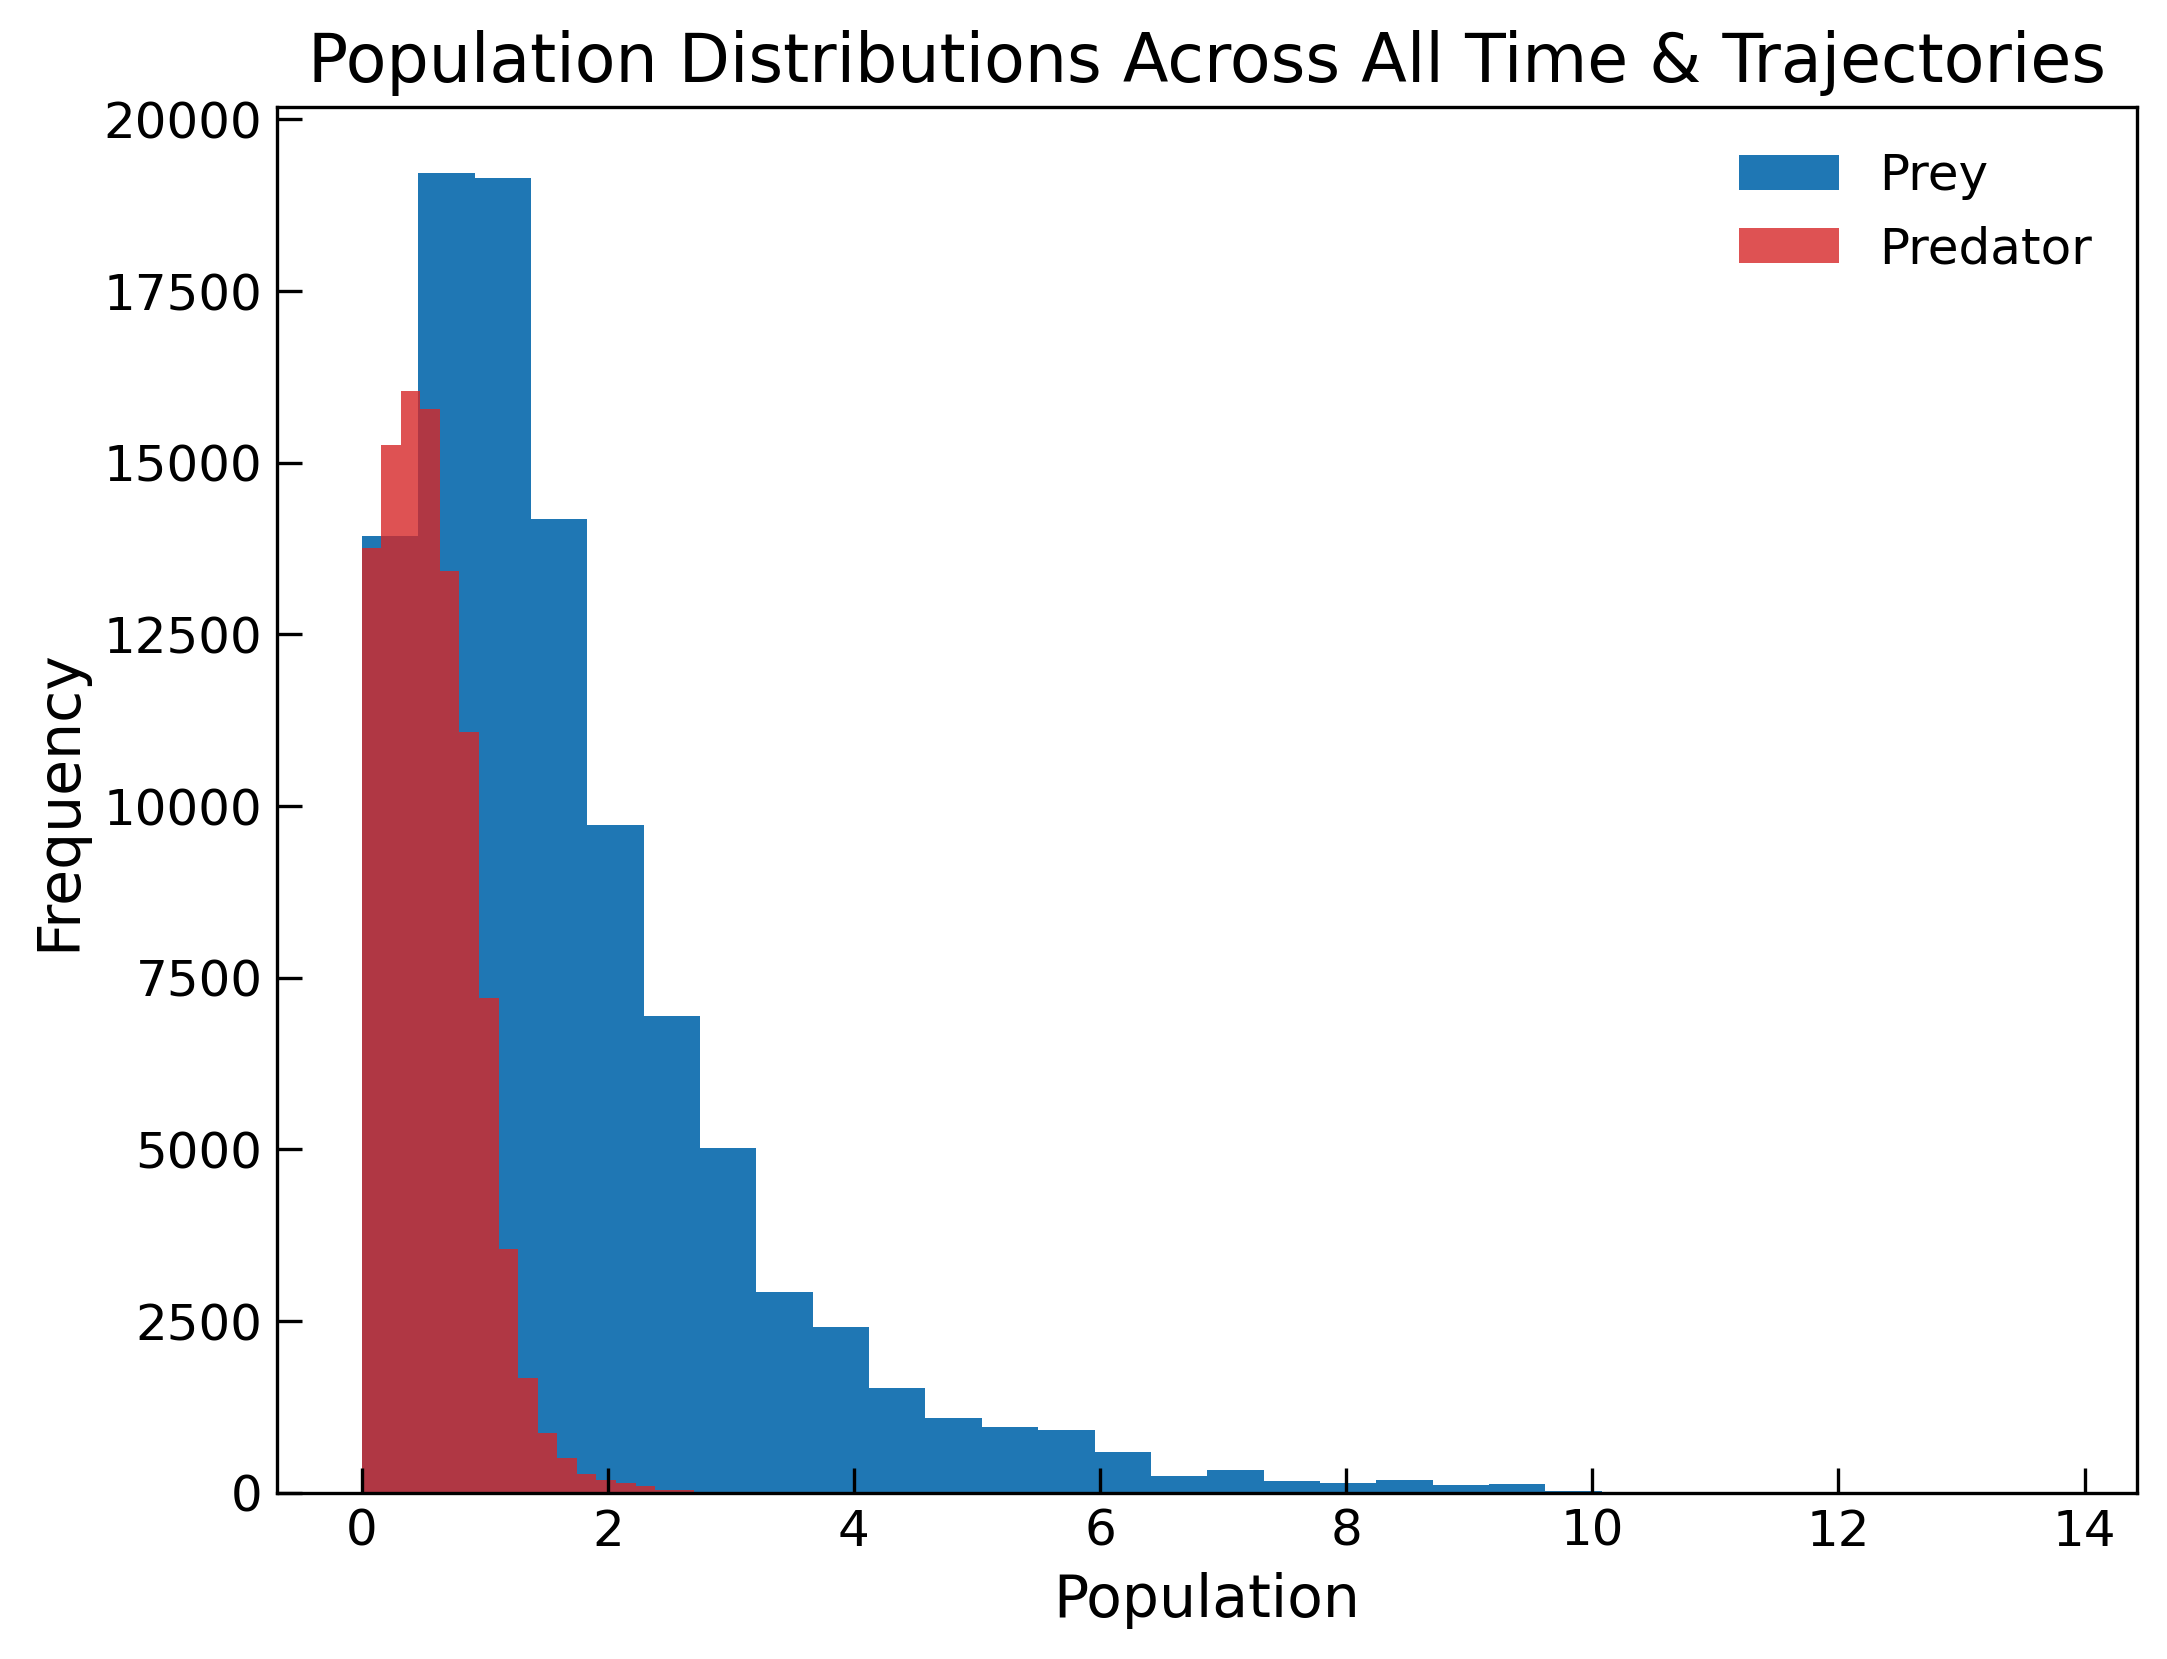

In [5]:
# Flatten populations into a single list - Shape: (num_trajectories * num_time_points,)
predator_population = trajectories[:, :, 1].flatten()  
prey_population = trajectories[:, :, 0].flatten()      

# Create histogram with both distributions in the same plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

ax.hist(prey_population, bins=30, color="tab:blue", alpha=1, label="Prey")
ax.hist(predator_population, bins=30, color="tab:red", alpha=0.8, label="Predator")


ax.set_xlabel("Population", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Population Distributions Across All Time & Trajectories", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
ax.legend(fontsize=12, frameon=False)
plt.show()

## Investigating the extreme cases

In [6]:
# Find the max values and their positions in the original 3D data - ie trajectory and time
# The value
predator_max = np.max(trajectories[:, :, 1])
prey_max = np.max(trajectories[:, :, 0])
# The positions
predator_max_index = np.unravel_index(np.argmax(trajectories[:, :, 1]), trajectories[:, :, 1].shape)
predator_max_dataset, predator_max_time = predator_max_index

prey_max_index = np.unravel_index(np.argmax(trajectories[:, :, 0]), trajectories[:, :, 0].shape)
prey_max_dataset, prey_max_time = prey_max_index

# Display the value, trajectory and time
print(f"Max Predator Population: {predator_max} at (Dataset={predator_max_dataset}, Time={predator_max_time})")
print(f"Max Prey Population: {prey_max} at (Dataset={prey_max_dataset}, Time={prey_max_time})")



Max Predator Population: 4.768490314483643 at (Dataset=567, Time=93)
Max Prey Population: 13.740113258361816 at (Dataset=322, Time=33)


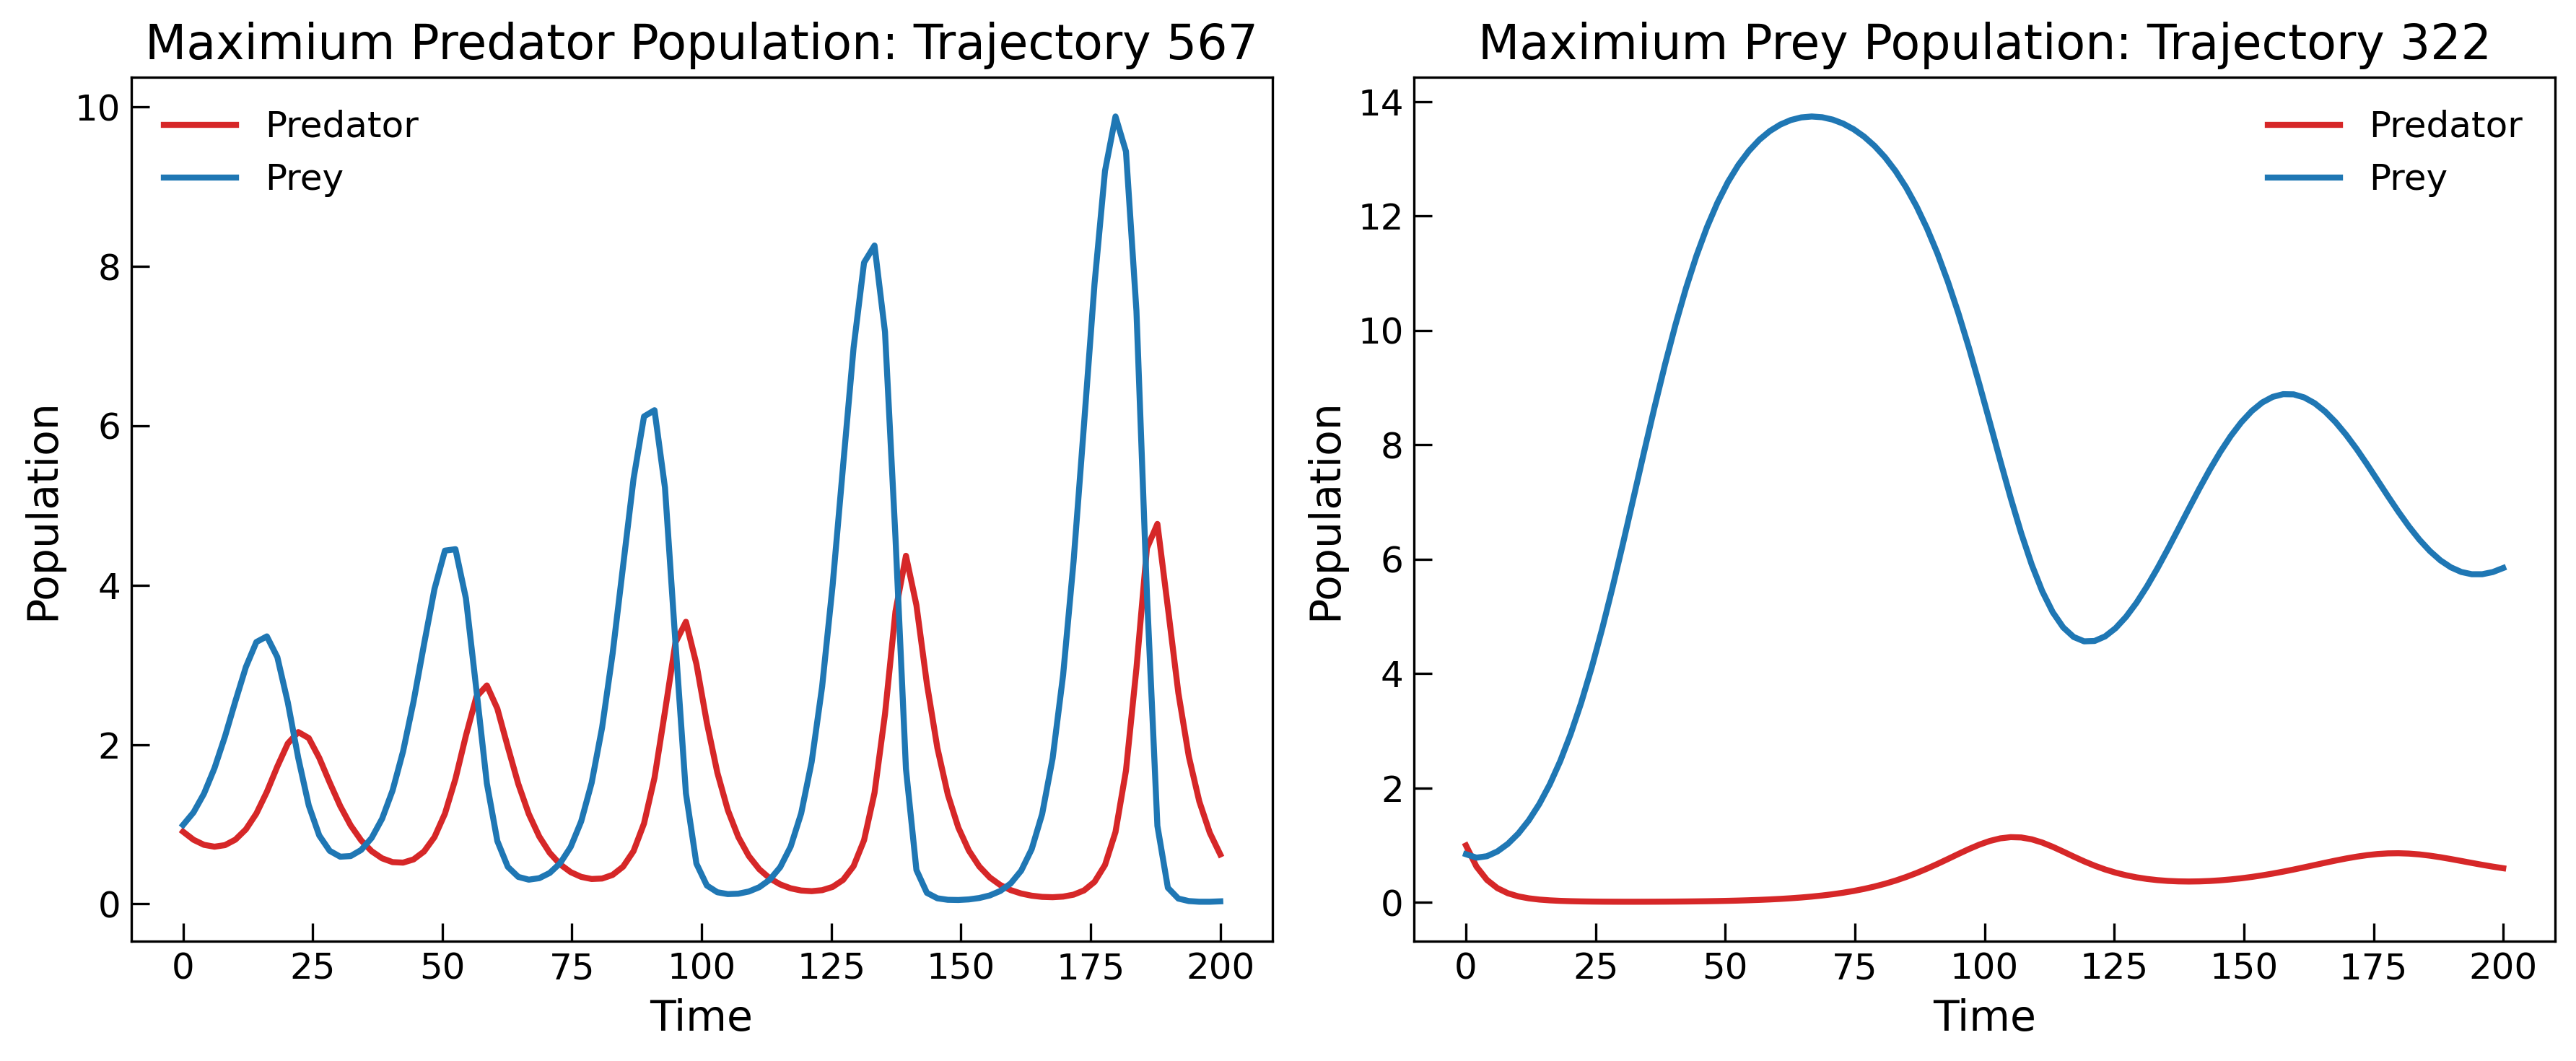

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Predator max dataset
idx_predator = predator_max_dataset
axes[0].plot(time_values, trajectories[idx_predator, :, 1], label="Predator", color="tab:red", linewidth=2)
axes[0].plot(time_values, trajectories[idx_predator, :, 0], label="Prey", color="tab:blue", linewidth=2)

axes[0].set_xlabel("Time", fontsize=14)
axes[0].set_ylabel("Population", fontsize=14)
axes[0].set_title(f"Maximium Predator Population: Trajectory {idx_predator}", fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
axes[0].legend(fontsize=12, frameon=False)

# Second subplot (for prey max dataset)
idx_prey = prey_max_dataset
axes[1].plot(time_values, trajectories[idx_prey, :, 1], label="Predator", color="tab:red", linewidth=2)
axes[1].plot(time_values, trajectories[idx_prey, :, 0], label="Prey", color="tab:blue", linewidth=2)

axes[1].set_xlabel("Time", fontsize=14)
axes[1].set_ylabel("Population", fontsize=14)
axes[1].set_title(f"Maximium Prey Population: Trajectory {idx_prey}", fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
axes[1].legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

## Discussion: Why Rescaling for Each Trajectory or Prey and Predator Separately is Invalid 
### This holds for our specific example and general differential equations of time series data

### 1. Rescaling Each Trajectory Separately
Rescaling each trajectory with a different factor introduces inconsistencies in the **Lotka-Volterra equations**. The equations describe the interaction between predator and prey populations:

$$
\frac{dx}{dt} = \alpha x - \beta xy
$$
$$
\frac{dy}{dt} = \delta xy - \gamma y
$$

If we apply **a different scaling factor $ s_t $ for each trajectory**, such that:
$$
x' = s_t x, \quad y' = s_t y
$$
where $ s_t $ vary across different trajectories, then the interaction terms transform into:

$$
\frac{dx'}{dt} = \alpha x' - s_t \beta x'y'
$$

$$
\frac{dy'}{dt} = s_t \delta x'y' - \gamma y'
$$

Since the interaction coefficients $ \beta $ and $ \delta $ now depend on the scaling factors $ s_t \beta $ and $ s_t \delta $, **each trajectory learns a different predator-prey relationship**, making it impossible to fit a single set of parameters for all data. The model would need to learn a specific set of equation for each, preventing generalisation across trajectories.

### 2. Rescaling Prey and Predator Separately
If we rescale **prey and predator populations independently**, using different scaling factors $ s_x $ and $ s_y $, the interaction terms ($ xy $) are no longer correctly preserved. The transformed equations become:

$$
\frac{dx'}{dt} = \alpha x' - \frac{s_x s_y}{s_x} \beta x'y' = \alpha x' - s_y \beta x'y'
$$

$$
\frac{dy'}{dt} = \frac{s_x s_y}{s_y} \delta x'y' - \gamma y' = s_x \delta x'y' - \gamma y'
$$

Here, the interaction terms ($ \beta xy $ and $ \delta xy $) now have different scaling factors, **distorting the balance between prey and predator interactions**. Since the predator-prey relationship relies on relative population sizes, introducing different scalings for prey and predator **breaks the fundamental symmetry of the equations**.


### Conclusion

All data must be scaled by the same **$\alpha$**: 

This alpha is chosen to be do the scaling such at 90% of data lies with the range 0-10. As outlined in Gruver et al 2023. it is advantageous to avoid scaling by the maximum value so the network can see a percentage of cases in which the number of digits exceeds this standard range and can predict accordingly, balancing training and robustness to outliers.


### Scaling Criteria
- Divide so that 90% of examples lie within 0-10. 

### Range Criteria
- Here we have taken the data to predominently lie between 0-10, this choice is arbitary as long as the precision, ie relation between decimal places and scale is constant
- Note we chose 10 as it seemed to show the best initial preformance results and able to account for periodicity the best

# NOTE:

### Caviet of choosing normalisation by 90% between 0-10
- Chosen as showed most promising initial preformance.
- By choosing this criteria, 10% of data points lie above 10 and thus have a give more tokens per value, although this adds complexity, it may also be the reason for its improved ability to understand the global scale of the larger numbers and greater predict periodicity.
- It was initially thought that the scale was arbitary and it would be advantageous to have all the same number of significant figures (ie supposedly 0-1000 would work well) but the presence of the decimal place and additional significant figures for the top 10% improves preformance.


In [8]:
# Determining alpha
# All data for both population (globally)
merged_data = np.concatenate([trajectories[:, :, 0].flatten(), trajectories[:, :, 1].flatten()])

# Compute the percentile across both
percentile_scale = np.percentile(merged_data, 90)

# Set the scaling factor (alpha)
alpha = percentile_scale / 10
print(f"Alpha: {alpha:.3f}")

# Tranforming the data 
# Apply the transformation to the original data
trajectories_scaled = trajectories / alpha

Alpha: 0.253


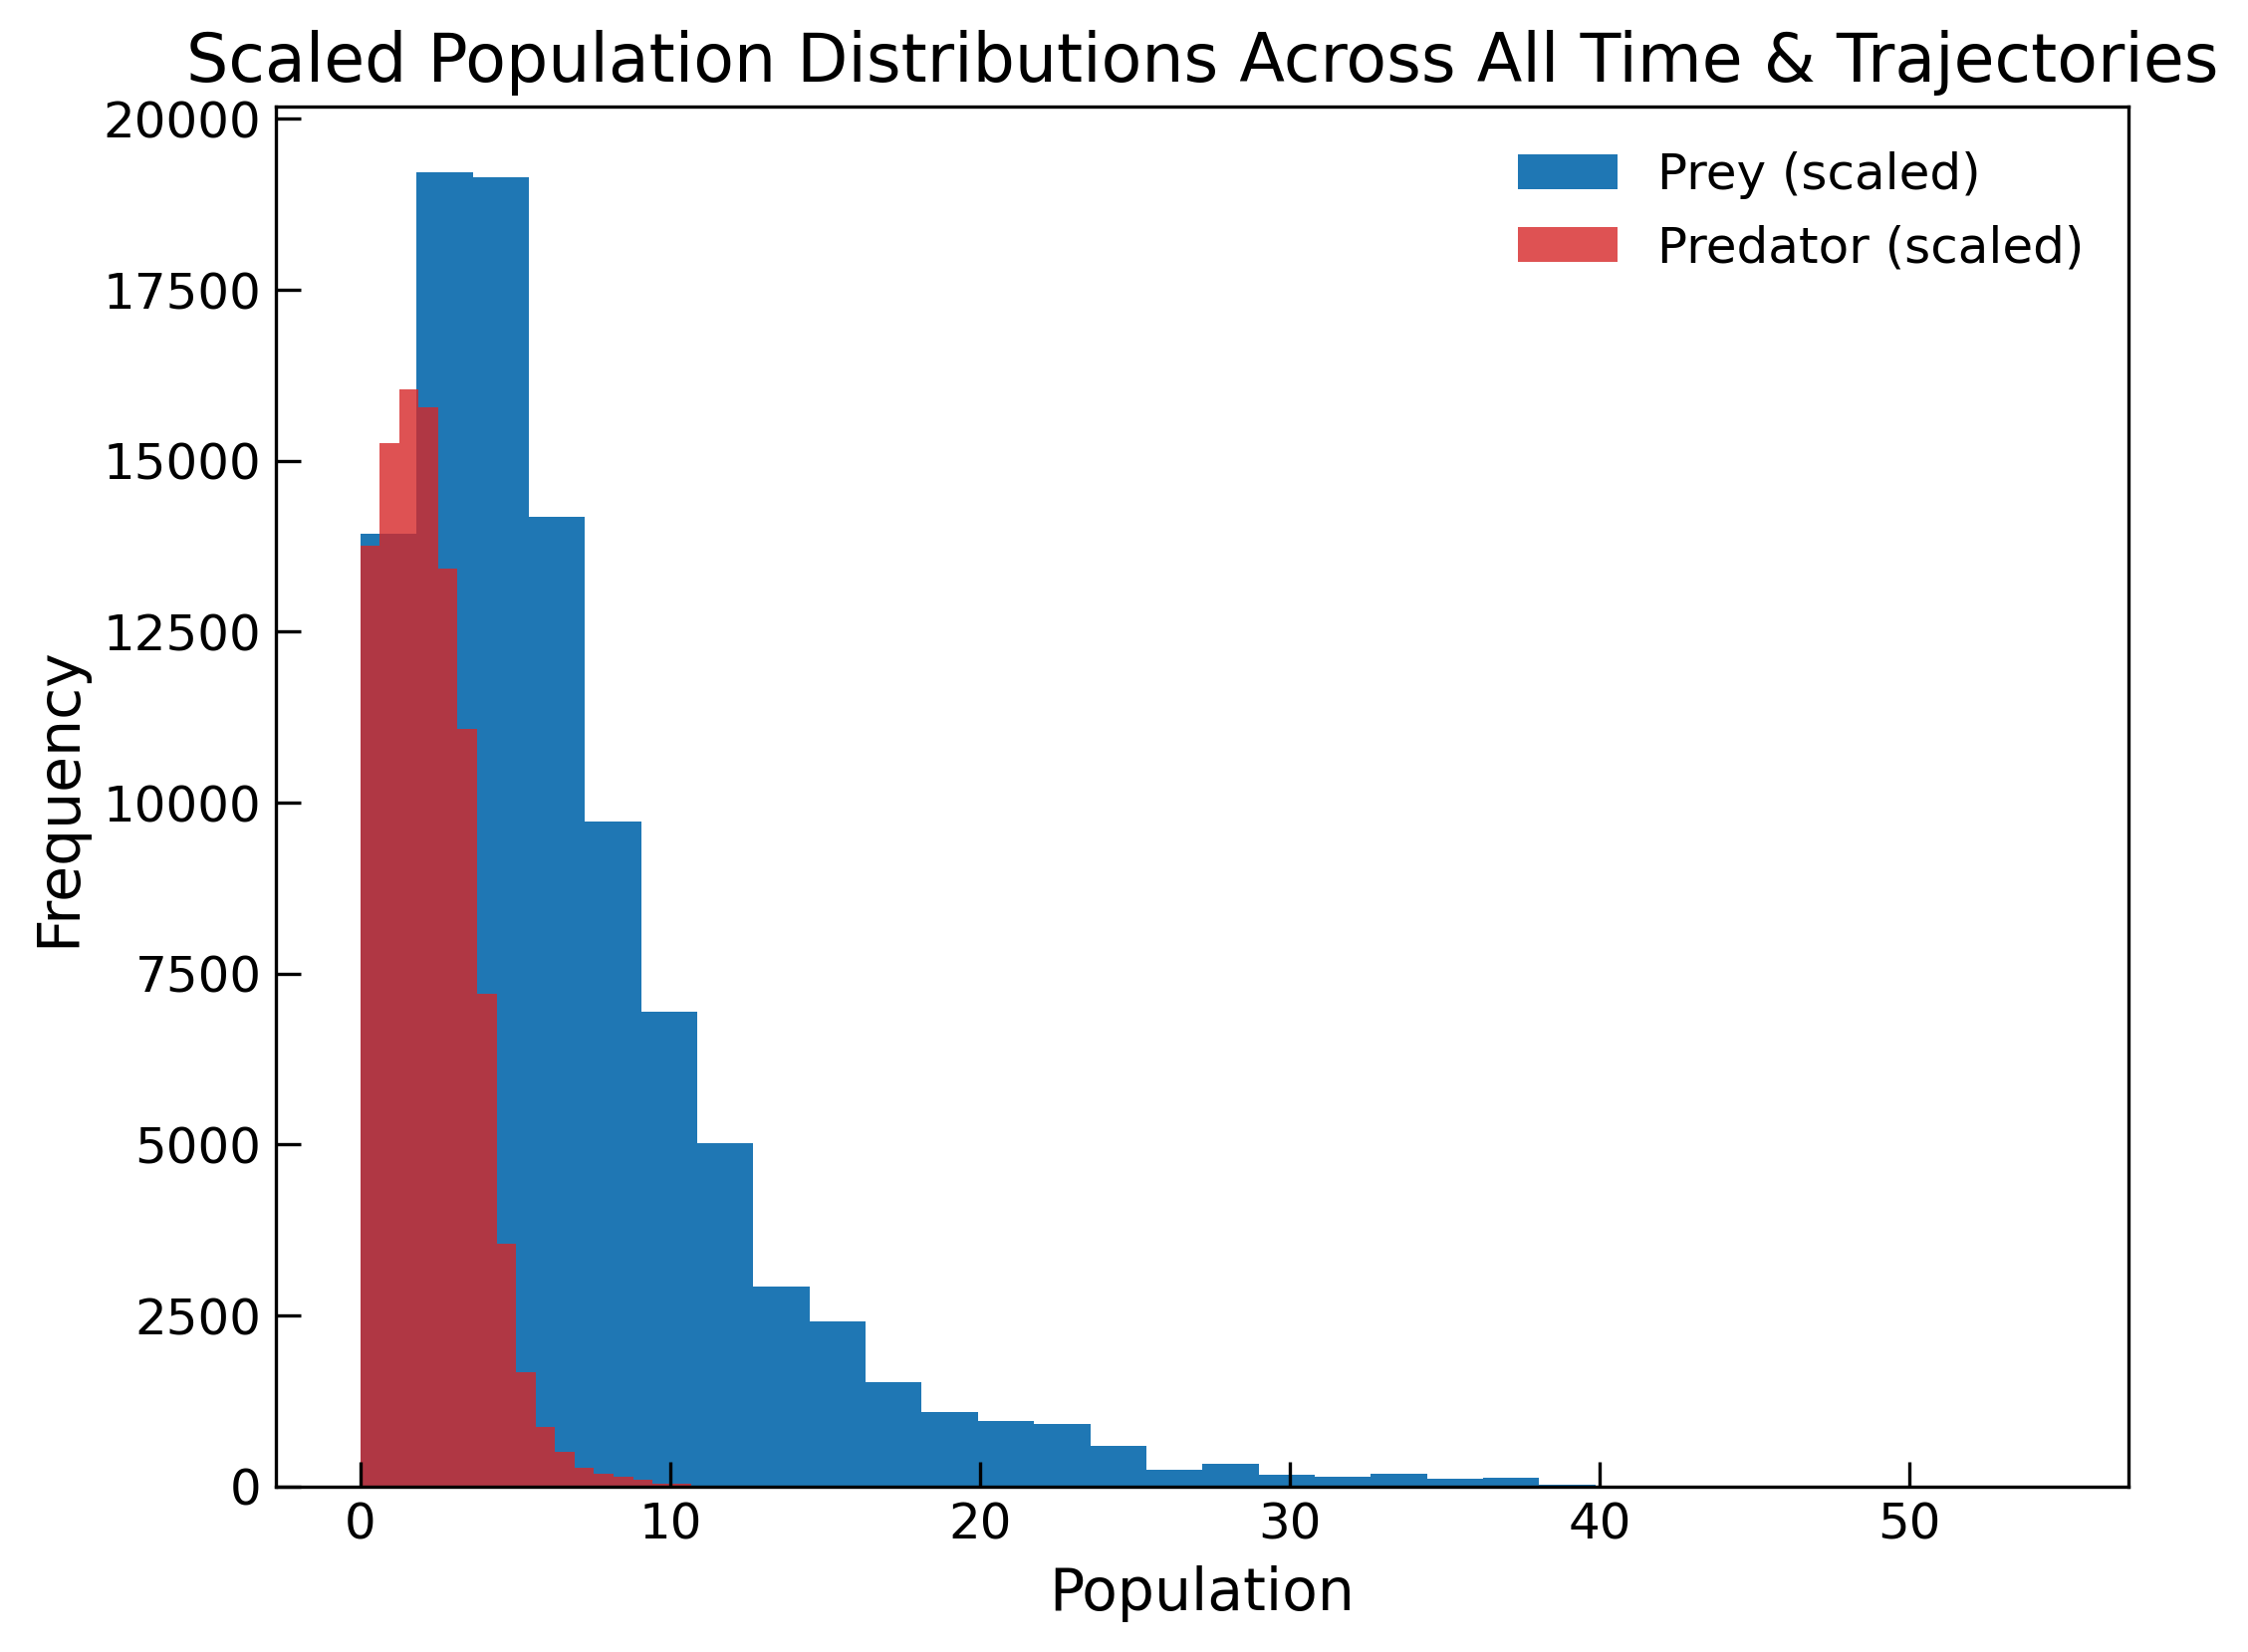

In [9]:
# Plot tranformed data
# Flatten populations into a single list - Shape: (num_trajectories * num_time_points,)
predator_population_scaled = trajectories_scaled[:, :, 1].flatten()  
prey_population_scaled = trajectories_scaled[:, :, 0].flatten()      

# Create histogram with both distributions in the same plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)


ax.hist(prey_population_scaled, bins=30, color="tab:blue", alpha=1, label="Prey (scaled)")
ax.hist(predator_population_scaled, bins=30, color="tab:red", alpha=0.8, label="Predator (scaled)")

ax.set_xlabel("Population", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Scaled Population Distributions Across All Time & Trajectories", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
ax.legend(fontsize=12, frameon=False)
plt.show()

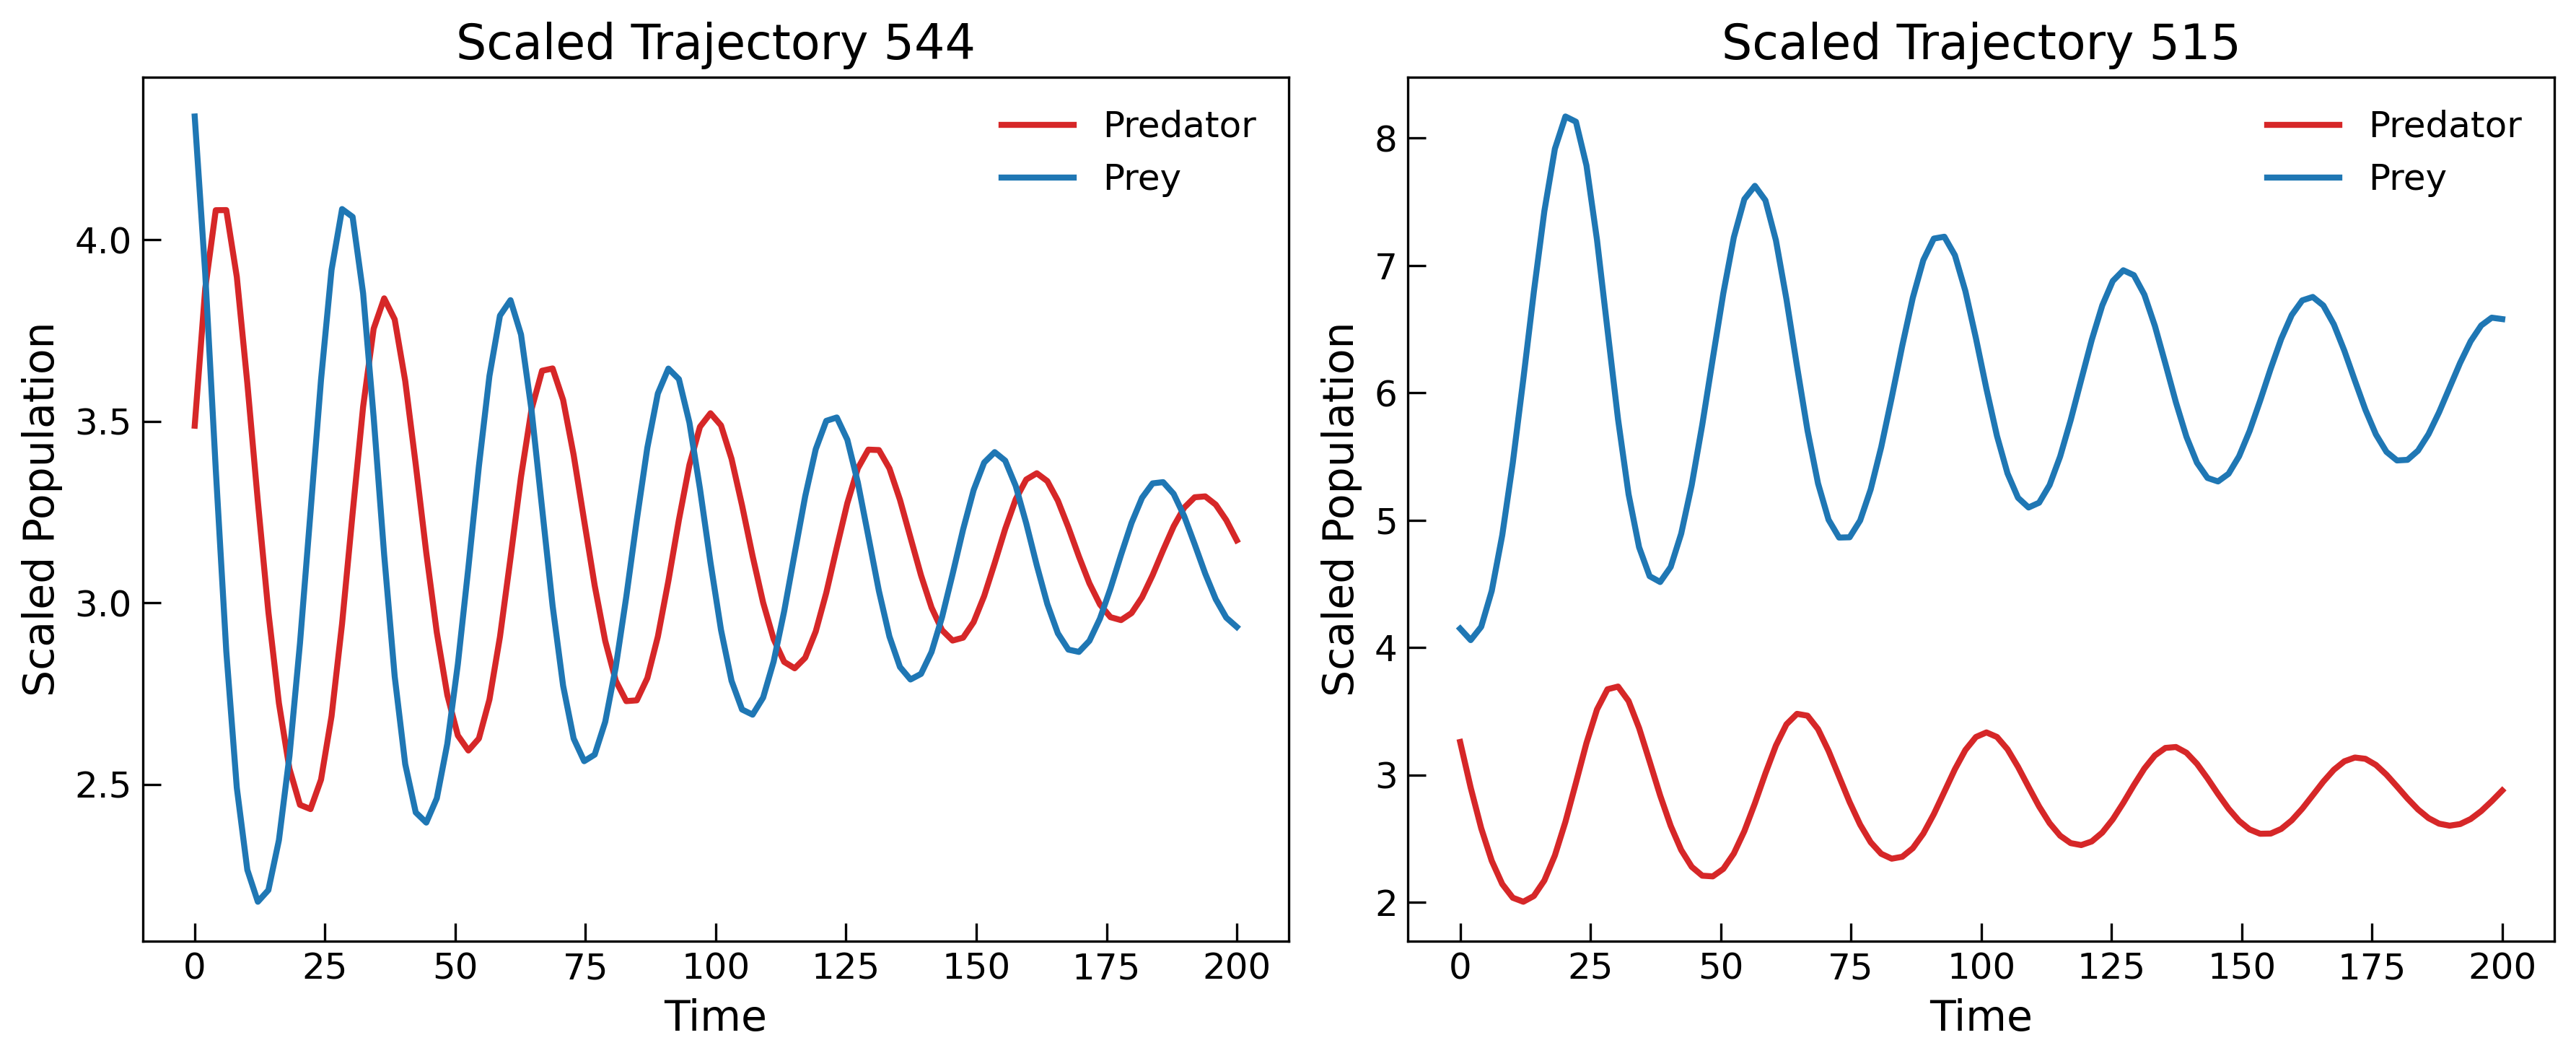

In [10]:
# Replot random trajectories
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

for i, ax in enumerate(axes):
    idx = random_indices[i]
    ax.plot(time_values, trajectories_scaled[idx, :, 1], label="Predator", color="tab:red", linewidth=2)
    ax.plot(time_values, trajectories_scaled[idx, :, 0], label="Prey", color="tab:blue", linewidth=2)
    
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Scaled Population", fontsize=14)
    ax.set_title(f"Scaled Trajectory {idx}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
    ax.legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

## The Resulting Processing function: 

`preprocessor` — Scale, Encode, and Split Time Series from file ready for Tokenisation in Data set

This function:
- loads Lotka-Volterra predator-prey time series data from the HDF5 file
- applies percentile-based scaling so most values fit in a normalized range
- encodes the scaled trajectories as semicolon-delimited strings like "1.23,0.87;1.24,0.88;..."
- optionally shuffles the data to ensure that there is no bias/ discrepency between sets
- splits the dataset into train, validation, and test sets based on configurable fractions
- optionally logs a detailed summary including tokenised examples using a provided Qwen-compatible tokenizer
- prints examples if desired

In [12]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokeniser_Qwen  = AutoTokenizer.from_pretrained(model_name)

In [13]:
train, validation, test = preprocessor('lotka_volterra_data.h5', percentile= 95,  train_fraction =0.7, validation_fraction= 0.15 , shuffle = False, tokeniser_model = tokeniser_Qwen)

INFO - File loaded successfully. Trajectories shape: (1000, 100, 2), Time points shape: (100,)
INFO - Scaling data by alpha=0.3473840057849884, ensuring 95% of values fit within the model's expected range.
INFO - Data scaled to 3 decimal places
INFO - Splitting the data into training, validation, and test sets with fractions: 0.7, 0.15, 0.15000000000000005
INFO - An example of the data encoding is shown below:

Example 1:
  Prey (raw):      ['2.734', '2.132', '1.964', '2.063', '2.373']
  Predator (raw):  ['2.996', '2.244', '1.625', '1.173', '0.864']
  String:          2.734,2.996;2.132,2.244;1.964,1.625;2.063,1.173;2.373,0.864
  Tokenised:       [17, 13, 22, 18, 19, 11, 17, 13, 24, 24, 21, 26, 17, 13, 16, 18, 17, 11, 17, 13, 17, 19, 19, 26, 16, 13, 24, 21, 19, 11, 16, 13, 21, 17, 20, 26, 17, 13, 15, 21, 18, 11, 16, 13, 16, 22, 18, 26, 17, 13, 18, 22, 18, 11, 15, 13, 23, 21, 19]

Example 2:
  Prey (raw):      ['2.797', '3.105', '3.629', '4.381', '5.356']
  Predator (raw):  ['2.894', '2.

## An example of De-Encoding Function

As above lets say our model returns 0.21,0.23;0.16,0.17;0.15,0.12;0.16,0.09;0.18,0.07 - it will need to decode this sequence

Dec`oder — Convert Encoded String Back to Time Series Arrays

This function:
- reverses the tokenisation-friendly string encoding used for input to the Qwen text based models 
- takes in a semicolon-separated string of prey,predator pairs
- returns two NumPy arrays containing the decoded prey and predator population values as floats

In [14]:
input_string = '0.21,0.23;0.16,0.17;0.15,0.12;0.16,0.09;0.18,0.07'
prey, pred = decoder(input_string)

print("Prey Data:", prey)
print("Predator Data:", pred)

Prey Data: [0.21 0.16 0.15 0.16]
Predator Data: [0.23 0.17 0.12 0.09]


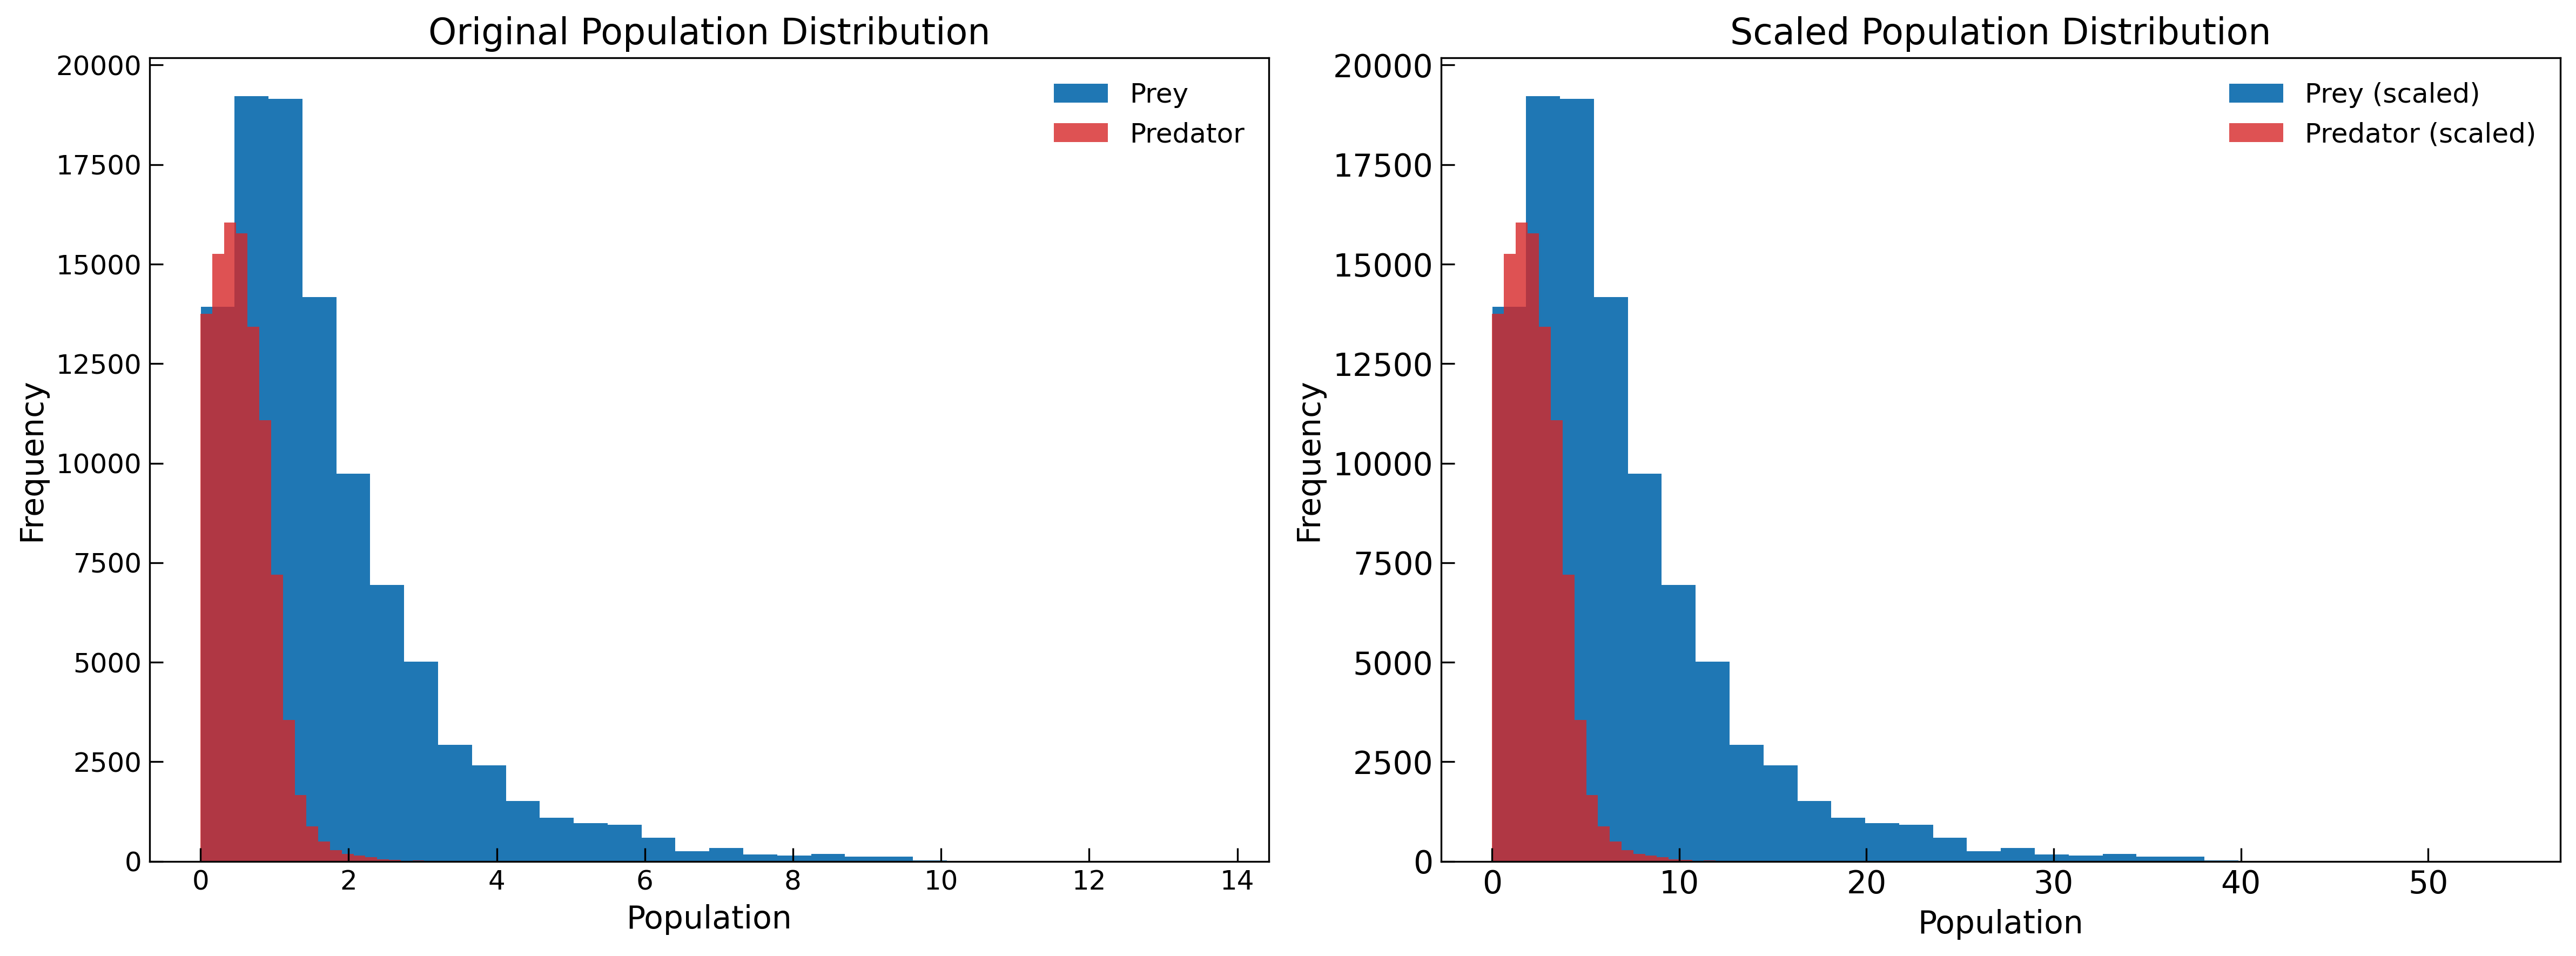

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Left plot: Original populations
axes[0].hist(prey_population, bins=30, color="tab:blue", alpha=1, label="Prey")
axes[0].hist(predator_population, bins=30, color="tab:red", alpha=0.8, label="Predator")
axes[0].set_title("Original Population Distribution", fontsize=16)
axes[0].set_xlabel("Population", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12, direction="in", length=6)
axes[0].legend(fontsize=12, frameon=False)

# Right plot: Scaled populations
axes[1].hist(prey_population_scaled, bins=30, color="tab:blue", alpha=1, label="Prey (scaled)")
axes[1].hist(predator_population_scaled, bins=30, color="tab:red", alpha=0.8, label="Predator (scaled)")
axes[1].set_title("Scaled Population Distribution", fontsize=16)
axes[1].set_xlabel("Population", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14, direction="in", length=6)
axes[1].legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.show()